# Email Classification

## Fetching data from MS-Sql

In [ ]:
!apt install unixodbc-dev
!pip install pyodbc

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
import os
import pyodbc
import urllib
import pandas as pd
from sqlalchemy import create_engine

In [ ]:
driver = [item for item in pyodbc.drivers()][-1]
conn_string = f'Driver={driver};Server=tcp:server.<domain>.com,<port>;Database=<db>;Uid=<userid>;Pwd=<pass>;Encrypt=yes;TrustServerCertificate=yes;Connection Timeout=30;'
conn = pyodbc.connect(conn_string)
cursor = conn.cursor()

In [ ]:
# params = urllib.parse.quote_plus(conn_string)
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
# engine_feat = create_engine(conn_str, echo=True)
# print(engine_feat.table_names())

In [ ]:
tname = 'tbl_Final_Lable_Data_18_n_19'
query = f'select count(*) from {tname}'

cursor.execute(query)
cursor.fetchall()

[(930913, )]

In [ ]:
query = f'select top 5 * from {tname}'
df = pd.read_sql(query, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   aglobalcaseid         5 non-null      int64 
 1   Team In               5 non-null      object
 2   Department            5 non-null      object
 3   QueryType             5 non-null      object
 4   SubQueryType          5 non-null      object
 5   Comment               5 non-null      object
 6   OriginalQuery         5 non-null      object
 7   OriginalSubQuery      5 non-null      object
 8   tSubject              5 non-null      object
 9   mMsgContent           5 non-null      object
 10  UmMsgContent          0 non-null      object
 11  MasterDepartment      5 non-null      object
 12  nCaseState            0 non-null      object
 13  nCreatedFromMedia     5 non-null      int64 
 14  Interaction_category  5 non-null      object
 15  LastTeamName          0 non-null      object

In [ ]:
%reload_ext google.colab.data_table

In [ ]:
df

In [ ]:
df.columns

Index(['aglobalcaseid', 'Team In', 'Department', 'QueryType', 'SubQueryType',
       'Comment', 'OriginalQuery', 'OriginalSubQuery', 'tSubject',
       'mMsgContent', 'UmMsgContent', 'MasterDepartment', 'nCaseState',
       'nCreatedFromMedia', 'Interaction_category', 'LastTeamName', 'Rating',
       'AcustId'],
      dtype='object')

In [ ]:
query = f'select tSubject, mMsgContent, QueryType, SubQueryType from {tname}'
df = pd.read_sql(query, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930913 entries, 0 to 930912
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tSubject      930913 non-null  object
 1   mMsgContent   716024 non-null  object
 2   QueryType     930913 non-null  object
 3   SubQueryType  930913 non-null  object
dtypes: object(4)
memory usage: 28.4+ MB


In [ ]:
df.to_pickle('data.p')

## Wrangling

In [ ]:
# wrangling.py
import os
import numpy as np
import pandas as pd
spath = '/content/email_class'
df = pd.read_pickle(os.path.join(spath,'data','raw','data.p'))
df.columns = ['subj','msg','qtype','stype']
df['type'] = df['qtype'] + ' | ' + df['stype']
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna(how='all')
df = df.drop_duplicates()
df = df.dropna(subset=['subj', 'msg'], how='all')
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna(how='all')
df = df.drop_duplicates()
df = df.dropna(subset=['subj', 'msg'], how='all')
df = df.fillna(' ')
df['subj&msg'] = df['subj'] + ' sub_eos_token ' + df['msg']
df = df[['subj&msg','type']]
df.columns = ['text','target']
df.sample(10000).to_pickle('df_raw_wrangled_sample_10k.p')
# df.sample(10000).to_pickle(os.path.join(spath,'data','wrangled','df_raw_wrangled_sample_10k.p'))
# df.to_pickle(os.path.join(spath,'data','wrangled','df_raw_wrangled_full.p'))

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [ ]:
df = pd.read_pickle(os.path.join(spath,'data','raw','data.p'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930913 entries, 0 to 930912
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tSubject      930913 non-null  object
 1   mMsgContent   716024 non-null  object
 2   QueryType     930913 non-null  object
 3   SubQueryType  930913 non-null  object
dtypes: object(4)
memory usage: 28.4+ MB


In [ ]:
df.sample(20)

In [ ]:
df.columns

In [ ]:
df.columns = ['subj','msg','qtype','stype']

In [ ]:
df.qtype.nunique()

In [ ]:
df.qtype.value_counts()[:50]

In [ ]:
df.stype.nunique()

270

In [ ]:
df.stype.value_counts()[:50]

In [ ]:
df['type'] = df['qtype'] + ' | ' + df['stype']

In [ ]:
df['type'].nunique()

500

In [ ]:
df['type'].value_counts()[:50]

In [ ]:
df.subj.nunique()

688740

In [ ]:
df.subj.value_counts()[:50]

In [ ]:
df.msg.nunique()

665982

In [ ]:
df.msg.value_counts()[:50]

In [ ]:
df[df.msg.isnull()].sample(10)

In [ ]:
df[(df.msg.isnull()) & (df.subj.isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   subj    0 non-null      object
 1   msg     0 non-null      object
 2   qtype   0 non-null      object
 3   stype   0 non-null      object
dtypes: object(4)
memory usage: 0.0+ bytes


In [ ]:
df2 = df.replace(r'^\s*$', np.nan, regex=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930913 entries, 0 to 930912
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   subj    907099 non-null  object
 1   msg     712917 non-null  object
 2   qtype   930913 non-null  object
 3   stype   585435 non-null  object
 4   type    930913 non-null  object
dtypes: object(5)
memory usage: 35.5+ MB


In [ ]:
df3 = df2.dropna(how='all')
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930913 entries, 0 to 930912
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   subj    907099 non-null  object
 1   msg     712917 non-null  object
 2   qtype   930913 non-null  object
 3   stype   585435 non-null  object
 4   type    930913 non-null  object
dtypes: object(5)
memory usage: 42.6+ MB


In [ ]:
df4 = df3.drop_duplicates()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873726 entries, 0 to 930912
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   subj    860490 non-null  object
 1   msg     684972 non-null  object
 2   qtype   873726 non-null  object
 3   stype   557609 non-null  object
 4   type    873726 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [ ]:
df4[(df4.msg.isnull()) & (df4.subj.isnull())]

In [ ]:
df5 = df4.dropna(subset=['subj', 'msg'], how='all')
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873578 entries, 0 to 930912
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   subj    860490 non-null  object
 1   msg     684972 non-null  object
 2   qtype   873578 non-null  object
 3   stype   557569 non-null  object
 4   type    873578 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


In [ ]:
df4.shape, df5.shape

((873726, 5), (873578, 5))

In [ ]:
sample = df5.sample(10)
sample

In [ ]:
!pip install ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
text_processor = TextPreProcessor(
  normalize=['url', 'email', 'percent', 'money', 'phone', 
              'user', 'time', 'date', 'number'],
  # annotate={"hashtag", "allcaps", "elongated", "repeated",
  #           'emphasis', 'censored'},
  fix_html=True,
  segmenter="twitter",
  corrector="twitter", 
  unpack_hashtags=True,
  unpack_contractions=True,
  spell_correct_elong=False,
  tokenizer=SocialTokenizer(lowercase=False).tokenize,
  dicts=[emoticons]
  )

In [ ]:
import re
from bs4 import BeautifulSoup

In [ ]:
# text_raw = sample.loc[[299500]].msg.tolist()[0]
# text = text_raw
# text = BeautifulSoup(text, "lxml").text
# text = re.sub(r'<.*?>', ' ', text)
# text = re.sub(r'\{[^{}]*\}', ' ', text)
# text = re.sub(r'\s', ' ', text)
# text = re.sub(r'.*\..*ID.*?(?=\s)', ' ', text)
# text = re.sub(r'DIV..*?(?=\s)', ' ', text)
# text = BeautifulSoup(text, "lxml").text
# text = text.strip()
# text = " ".join(text_processor.pre_process_doc(text))
# text

In [ ]:
from itertools import groupby

In [ ]:
html_residual = 'P . ImprintUniqueID LI . ImprintUniqueID DIV . ImprintUniqueID TABLE . ImprintUniqueIDTable DIV . Section '
caution_residual =  'CAUTION This email originated from outside of the organization . Do not click links or open attachments unless you recognize the sender and know the content is safe . '

In [ ]:
def clean_text(text):
  text = ' ' + text + ' '
  text = BeautifulSoup(text, "lxml").text
  text = re.sub(r'<.*?>', ' ', text)
  text = re.sub(r'\{[^{}]*\}', ' ', text)
  text = re.sub(r'\s', ' ', text)
  # text = re.sub(r'(?=\s).*\..*ID.*?(?=\s)', ' ', text)
  # text = re.sub(r'(?=\s)DIV..*?(?=\s)', ' ', text)
  text = re.sub(r'Forwarded message.*?(?=____)', ' ', text)
  text = BeautifulSoup(text, "lxml").text
  text = ' '.join(text_processor.pre_process_doc(text))
  text = re.sub(r'[^A-Za-z<>. ]', ' ', text)
  text = ' '.join(text.split())
  text = re.sub(html_residual, '', text)
  text = re.sub(caution_residual, '', text)
  text = re.sub(r'(?:\d+[a-zA-Z]+|[a-zA-Z]+\d+)', '<hash>', text)
  # text = re.sub(r'\b\w{1,2}\b', '', text)
  text = ' '.join(text.split())
  text = ' '.join([k for k,v in groupby(text.split())])
  return text

In [ ]:
# # text_raw = sample.loc[[75806]].msg.tolist()[0]
# text = text_raw
# text = BeautifulSoup(text, "lxml").text
# text = re.sub(r'<.*?>', ' ', text)
# text = re.sub(r'\{[^{}]*\}', ' ', text)
# text = re.sub(r'\s', ' ', text)
# # text = re.sub(r'.*\..*ID.*?(?=\s)', ' ', text)
# # text = re.sub(r'DIV..*?(?=\s)', ' ', text)
# text = re.sub(r'Forwarded message.*?(?=____)', ' ', text)
# text = BeautifulSoup(text, "lxml").text
# text = " ".join(text_processor.pre_process_doc(text))
# text = re.sub(r'[^A-Za-z0-9<>. ]', ' ', text)
# text = ' '.join(text.split())
# text

In [ ]:
sample = df5.sample(1000)

In [ ]:
sample['subj_clean'] = sample['subj'].fillna(' ').apply(clean_text)

In [ ]:
[(x,y) for x,y in zip(sample.subj.tolist()[:50],sample.subj_clean.tolist()[:50])]

In [ ]:
sample['msg_clean'] = sample['msg'].fillna(' ').apply(clean_text)
sample.msg.tolist()

In [ ]:
sample.msg_clean.tolist()

In [ ]:
sample = df5.sample(1000, random_state=40)
sample['subj_clean'] = sample['subj'].fillna(' ').apply(clean_text)
sample['msg_clean'] = sample['msg'].fillna(' ').apply(clean_text)
sample['subj&msg'] = sample['subj_clean'] + ' | ' + sample['msg_clean']
sample = sample[['subj&msg','type']]
sample.columns = ['text','target']
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 36966 to 574457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   target  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [ ]:
sample

In [ ]:
sample = df5.copy()
sample['subj_clean'] = sample['subj'].fillna(' ').apply(clean_text)
sample['msg_clean'] = sample['msg'].fillna(' ').apply(clean_text)
sample['subj&msg'] = sample['subj_clean'] + ' | ' + sample['msg_clean']
sample = sample[['subj&msg','type']]
sample.columns = ['text','target']
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873578 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    873578 non-null  object
 1   target  873578 non-null  object
dtypes: object(2)
memory usage: 20.0+ MB


In [ ]:
sample.nunique()

text      803255
target       500
dtype: int64

In [ ]:
sample2 = sample.drop_duplicates()
sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820778 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    820778 non-null  object
 1   target  820778 non-null  object
dtypes: object(2)
memory usage: 18.8+ MB


In [ ]:
sample3 = sample2.replace(r'^\s*$', np.nan, regex=True)
sample3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820778 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    820778 non-null  object
 1   target  820778 non-null  object
dtypes: object(2)
memory usage: 18.8+ MB


In [ ]:
df5.to_pickle('df_raw_wrangled.p')

In [ ]:
sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820778 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    820778 non-null  object
 1   target  820778 non-null  object
dtypes: object(2)
memory usage: 18.8+ MB


In [ ]:
sample2.nunique()

text      803255
target       500
dtype: int64

In [ ]:
sample2.describe()

## Text Cleaning

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer() 

from nltk.stem import PorterStemmer
ps = PorterStemmer()

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [ ]:
df = pd.read_pickle(os.path.join(path,'data','wrangled','df_raw_wrangled_sample_10k.p'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 930773 to 629839
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   target  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [ ]:
df.sample(5)

In [ ]:
df[df.target=='<redacted>'].sample(5)

In [ ]:
df.target.value_counts()

In [ ]:
# # cleaning pipe
# - lowercase
# - remove nonalpha
# - stopword
# - lemmatization
# - stemming

# - min occurence
# - max occurence
# - ngram
# - misspell
# - contraction

# - encode plus tokenizer

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# label tokens
caution_label = 'CAUTION: This email originated from outside of the organization. \
Do not click links or open attachments unless you recognize the sender and know the \
content is safe'

confidential_label = '<redacted>'

confidential_label = '<redacted>'

retransmit_label = '<redacted>'

alert_label = '<redacted>'

html_labels = ['P.ImprintUniqueID', 'LI.ImprintUniqueID', 'DIV.ImprintUniqueID',
              'TABLE.ImprintUniqueIDTable', 'DIV.Section1']
html_regex = re.compile('|'.join(map(re.escape, html_labels)))

newline_token = '\n'


custom_stopwords = ['best', 'regard', 'direct', 'number', 'phone', 'mobile', 'number', 'reply', 'url', 'com']


In [ ]:
!pip install clean-text

In [ ]:
def clean_l1(text):
  text = re.sub(caution_label, ' cautionlabel ', text)
  text = re.sub(confidential_label, ' confidentiallabel ', text)
  text = html_regex.sub('htmltoken', text)
  text = re.sub(retransmit_label, ' retransmittoken ', text)
  text = re.sub(alert_label, ' alerttoken ', text)
  text = re.sub('sub_eos_token', ' bodytoken ', text)
  text = ' ' + text + ' '
  text = BeautifulSoup(text, "lxml").text
  text = re.sub(r'<.*?>', ' ', text)
  text = re.sub(r'\{[^{}]*\}', ' ', text)
  # # text = re.sub(r'Forwarded message.*?(?=____)', ' ', text)
  text = BeautifulSoup(text, "lxml").text
  text = re.sub(newline_token, ' newlinetoken ', text)
  text = ' '.join(text.split())
  text = re.sub(r'[^A-Za-z.,?\'@]', ' ', text)
  

  # text = ' '.join(text.split())
  return text

In [ ]:
xx = clean_l1(df.loc[idx,'text']); xx
# print(xx)

In [ ]:
df.loc[idx,'text']

In [ ]:
idx = np.random.randint(0,len(df))
print(idx)
print(df.loc[idx,'text'])

In [ ]:
# idx = 9
# print(df.text.iloc[[idx]].tolist()[0])
# xx = df.text.iloc[[idx]].apply(clean_l1).tolist()[0]
# xx

In [ ]:
df['text_clean_l1'] = df.text.apply(clean_l1)

In [ ]:
df.text_clean_l1.sample().tolist()[0]

In [ ]:
set1_words = ['best regards', 'regards', 'thanks regards', 'warm regards']
set1_regex = re.compile('|'.join(map(re.escape, set1_words)))

In [ ]:
from itertools import groupby

In [ ]:
def replace_words(s, words):
  for k, v in words.items():
      s = s.replace(k, v)
  return s

word_mapping = {' f o ':' fno ',
                ' a c ':' account ',
                ' a/c ':' account ',
                ' fw ':' forward ',
                ' fwd ':' forward ',
                ' forwarded ':' forward ',
                ' no. ':' number ',
                }

In [ ]:
def clean_l2(text):
  text = ' ' + text + ' '
  text = text.lower()
  text = ' '.join(text.split())
  text = replace_words(text, word_mapping)
  text = re.sub('[.]', ' . ', text)
  text = re.sub('[,]', ' , ', text)
  text = re.sub('[?]', ' ? ', text)
  text = ' '.join([w for w in text.split() if re.match('^[a-z.,?\'\-\~#`!&*()]+$', w)])
  text = re.sub(r'[^a-z.,?\']', ' ', text)
  text = set1_regex.sub('eostoken', text)
  text = text + ' eostoken '
  text = re.match(r'^.*?eostoken', text).group(0)
  text = re.sub(r'eostoken', '', text)
  text = re.sub(r'\b\w{1,1}\b', '', text)
  text = ' '.join([k for k,v in groupby(text.split())])
  text = ' '.join(text.split())
  return text

In [ ]:
xxy = 'warm regards regrads hello regards'
xxy = ' '.join([w for w in xxy.split() if re.match('^[a-z.,?\'\-\~#`!&*()]+$', w)])
xxy = re.sub(r'[^a-z.,?\']', ' ', xxy)
xxy = set1_regex.sub('eostoken', xxy)
re.match(r'^.*?eostoken', xxy).group(0)

'warm eostoken'

In [ ]:
idx = 1
# print(df.text.iloc[[idx]].tolist()[0])
print(df.text_clean_l1.iloc[[idx]].tolist()[0])
df.text_clean_l1.iloc[[idx]].apply(clean_l2).tolist()[0]

In [ ]:
df['text_clean_l2'] = df.text_clean_l1.apply(clean_l2)

In [ ]:
df.drop_duplicates().replace(r'^\s*$', np.nan, regex=True).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 930773 to 629839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           10000 non-null  object
 1   target         10000 non-null  object
 2   text_clean_l1  10000 non-null  object
 3   text_clean_l2  9999 non-null   object
dtypes: object(4)
memory usage: 390.6+ KB


(0, 1544)

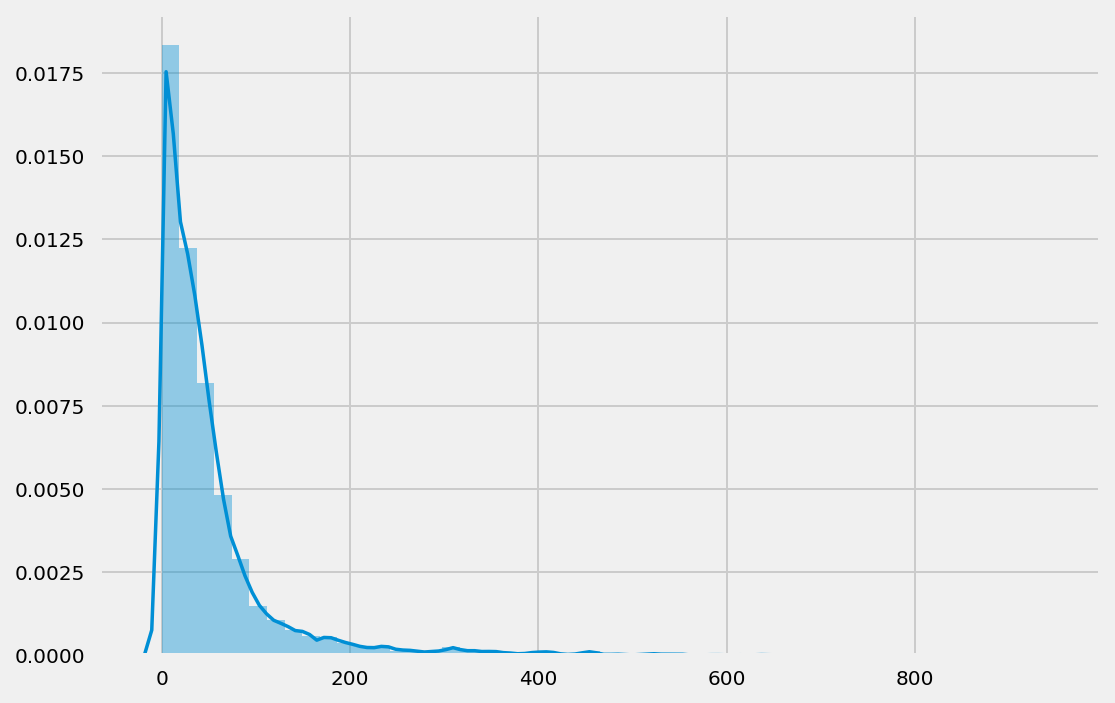

In [ ]:
xx = df.text_clean_l2.apply(lambda x: len(x.split())).values
sns.distplot(xx[xx<1000])
xx.min(), xx.max()

In [ ]:
# print(np.argmax(-xx))
print(list(np.argsort(-xx))[:20])
df.iloc[[374]]

In [ ]:
df1 = df[(df.text_clean_l2.apply(lambda x: len(x.split()))>3) & (df.text_clean_l2.apply(lambda x: len(x.split()))<200)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9012 entries, 930773 to 629839
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           9012 non-null   object
 1   target         9012 non-null   object
 2   text_clean_l1  9012 non-null   object
 3   text_clean_l2  9012 non-null   object
dtypes: object(4)
memory usage: 352.0+ KB


In [ ]:
def clean_l3(text):
  text = re.sub(r'[^a-z]', '', text)
  text = ' '.join([lemmatizer.lemmatize(w, 'v') for w in text.split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
  text = ' '.join([w for w in text.split() if not w in stopwords])
  text = ' '.join([w for w in text.split() if not w in custom_stopwords])
  # seen = set()
  # seen_add = seen.add
  # text = ' '.join([x for x in text.split() if not (x in seen or seen_add(x))])
  text = ' '.join([ps.stem(w) for w in text.split()])
  return text

In [ ]:
# def temp(text):
#   text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
#   text = ' '.join([lemmatizer.lemmatize(w, 'j') for w in text.split()])
#   text = ' '.join([lemmatizer.lemmatize(w, 'V') for w in text.split()])
#   text = ' '.join([lemmatizer.lemmatize(w, 'R') for w in text.split()])
#   return text

# # temp('communicate communication')

# import spacy
# from spacy.lemmatizer import Lemmatizer, ADJ, NOUN, VERB
# lemmatizer = nlp.vocab.morphology.lemmatizer
# lemmatizer('communicate communication', VERB)

# from nltk.stem import PorterStemmer
# ps = PorterStemmer()
# for w in ['commute', 'communication']:
#     rootWord=ps.stem(w)
#     print(rootWord)

In [ ]:
df['text_clean_l2'] = df.text_clean_l1.apply(clean_l2)

In [ ]:
df.text_clean_l2.sample(5, random_state=10).tolist()

In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_sm")

# def ners(text):
#   doc = nlp(text)
  # for token in doc:
  #   print(token.text)
  # x = list(set([ent.text for ent in doc.ents if ent.label_=='ORG']))
  # x = list(set([(ent.text,ent.label_) for ent in doc.ents]))
  # return x

# df.sample(20).text.apply(ners).tolist()
# df.text.iloc[[14]].apply(ners)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,3))
vectorizer.fit_transform(df.clean.tolist())

<10000x5456 sparse matrix of type '<class 'numpy.int64'>'
	with 270546 stored elements in Compressed Sparse Row format>

In [ ]:
idx = 100
print(df.text.iloc[[idx]].tolist()[0])
pd.DataFrame(vectorizer.inverse_transform(vectorizer.transform([df.clean.tolist()[idx]]))).T[0]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=10, ngram_range=(1,2))
X = vect.fit_transform(df.clean.tolist())

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()

In [ ]:
idx = 14
print(df.text.iloc[[idx]].tolist()[0])
print(top_feats_in_doc(X, features, idx, 10))

In [ ]:
df[df.clean.str.contains('vora')]

## Transformer model

In [ ]:
!pip install -q clean-text[gpl] && cp '/content/drive/My Drive/clean_v2.py' .
from clean_v2 import clean_l1

In [ ]:
import os
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import csv

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [ ]:
df_raw = pd.read_pickle(os.path.join(path,'data_clean_v2.p'))
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824410 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    824410 non-null  object
 1   target  824410 non-null  object
dtypes: object(2)
memory usage: 18.9+ MB


In [ ]:
df = df_raw.sample(10000, random_state=42)

In [ ]:
tokenlist = ['emailtoken', 'urltoken', 'newlinetoken', 'htmltoken', 'currencytoken', 'token', 'digittoken', 'numbertoken']
def preprocess(text):
  text = text.lower()
  text = ' '.join([w for w in text.split() if w not in tokenlist])
  text = ' '.join(text.split()[:50])
  return text
df['text'] = df.text.apply(preprocess)
df = df[df.text.apply(lambda x: len(x.split()))>3]

In [ ]:
df['target'] = df.target.apply(clean_l1).str.lower().str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')
minority_labels = df.target.value_counts()[df.target.value_counts()<100].index.tolist()
df['target'] = df.target.replace(dict.fromkeys(minority_labels, 'other'))

In [ ]:
df = df[df.target!='other']
df.target.value_counts()[:25]

In [ ]:
target_map = {'<redacted>': '<redacted>'}
df = df.replace({'target': target_map})
df.target.value_counts()[:25]

In [ ]:
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

In [ ]:
df.head()

In [ ]:
with open('label.csv', 'w') as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(df.target.unique().tolist())

In [ ]:
train, val = train_test_split(df, test_size=0.2, random_state=42)
train.reset_index(drop=True).to_csv('train.csv')
val.reset_index(drop=True).to_csv('val.csv')

In [ ]:
!pip install -q fast-bert

In [ ]:
from fast_bert.data_cls import BertDataBunch

databunch = BertDataBunch('/content', '/content',
                          tokenizer='distilbert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='label.csv',
                          text_col='text',
                          label_col='target',
                          batch_size_per_gpu=16,
                          max_seq_length=100,
                          multi_gpu=False,
                          multi_label=False,
                          model_type='distilbert')

In [ ]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging
import torch

logger = logging.getLogger()
device_cuda = 'cuda' if torch.cuda.is_available() else 'cpu'
metrics = [{'name': 'accuracy', 'function': accuracy}]

In [ ]:
learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='distilbert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='/content',
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=False,
						is_fp16=True,
						multi_label=False,
						logging_steps=50)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


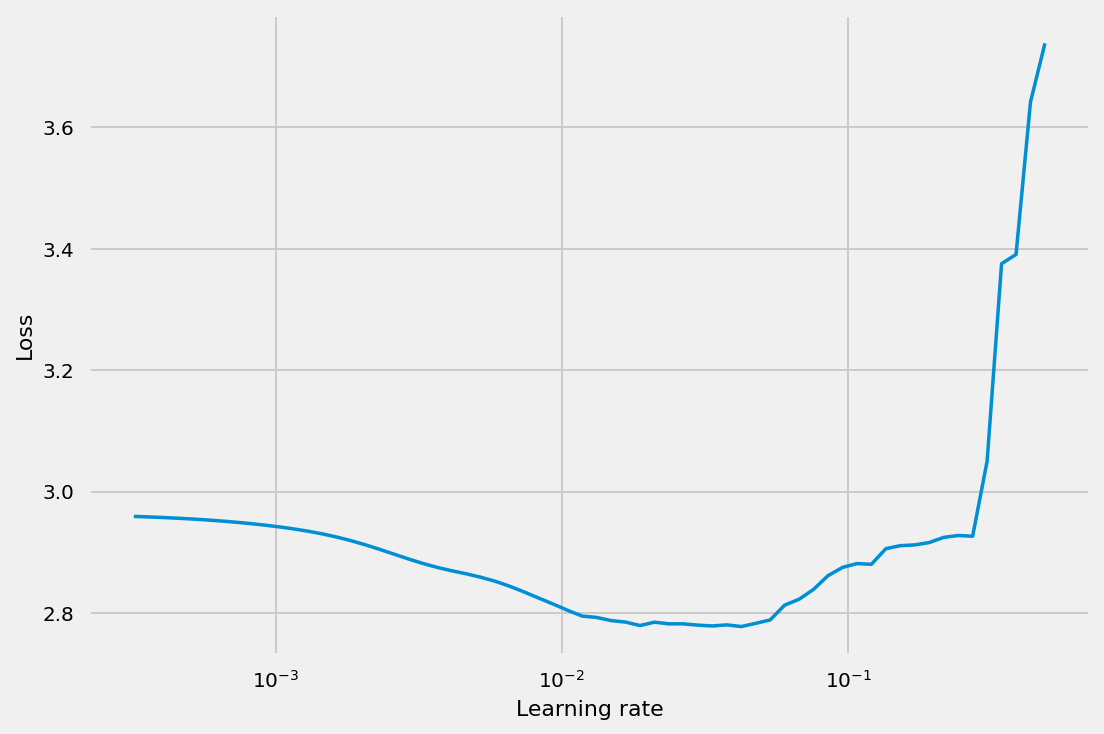

In [ ]:
learner.lr_find(start_lr=1e-4,optimizer_type='lamb')

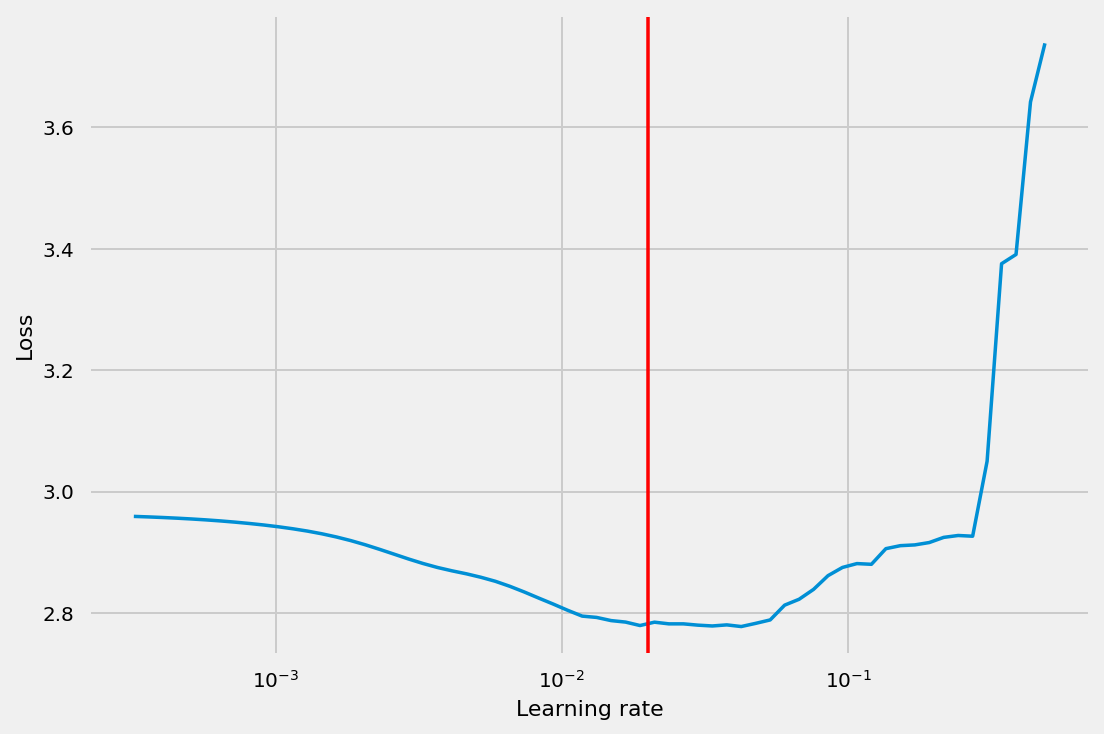

In [ ]:
learner.plot(show_lr=2e-2)

In [ ]:
 learner.fit(epochs=1,
            lr=2e-2,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="lamb",
            return_results=True)

(206,
 1.1582254237920335,
 [{'accuracy': 0.5176184690157959, 'loss': 1.860094638971182}])

In [ ]:
learner.validate()

{'accuracy': 0.5820170109356014, 'loss': 1.515815230516287}

In [ ]:
learner.save_model()

In [ ]:
xx = val.sample(5); xx

In [ ]:
predictions = learner.predict_batch(xx.text.tolist())
pd.DataFrame(predictions).T

,0,1,2,3,4
0,"(13, 0.5029970407485962)","(1, 0.2849506437778473)","(18, 0.9671371579170227)","(13, 0.49702489376068115)","(13, 0.4963048994541168)"
1,"(12, 0.4361490309238434)","(14, 0.19909745454788208)","(15, 0.02038804441690445)","(12, 0.44182324409484863)","(12, 0.4420331120491028)"
2,"(6, 0.040604788810014725)","(3, 0.1462075114250183)","(8, 0.00474834768101573)","(6, 0.04138932377099991)","(6, 0.042018480598926544)"
3,"(8, 0.004319680389016867)","(7, 0.09595444053411484)","(7, 0.003041398013010621)","(8, 0.0043030548840761185)","(8, 0.004299752414226532)"
4,"(15, 0.003917133901268244)","(2, 0.054793670773506165)","(3, 0.0015623067738488317)","(15, 0.0040094563737511635)","(15, 0.0039185951463878155)"
5,"(3, 0.0034547557588666677)","(8, 0.05304568260908127)","(2, 0.0008312677964568138)","(3, 0.0033589242957532406)","(3, 0.003347844583913684)"
6,"(7, 0.002314438344910741)","(16, 0.05202994868159294)","(13, 0.0008070677286013961)","(7, 0.002267843810841441)","(7, 0.0022567221894860268)"
7,"(2, 0.0019395719282329082)","(9, 0.025353267788887024)","(5, 0.00041077929199673235)","(2, 0.001761327381245792)","(2, 0.0017566184978932142)"
8,"(1, 0.001005849102512002)","(5, 0.01899590902030468)","(1, 0.00022466160589829087)","(1, 0.0009421476861461997)","(1, 0.0009516084683127701)"
9,"(11, 0.0008657740545459092)","(15, 0.013103190809488297)","(16, 0.00021143603953532875)","(11, 0.0007745196344330907)","(11, 0.0007488682167604566)"


In [ ]:
# from fast_bert.prediction import BertClassificationPredictor
# MODEL_PATH = '/content/model_out'

# predictor = BertClassificationPredictor(
# 				model_path='/content',
# 				label_path='/content',
# 				multi_label=False,
# 				model_type='xlnet',
# 				do_lower_case=True)

# single_prediction = predictor.predict("just get me result for this text")
# texts = ["this is the first text", "this is the second text"]
# multiple_predictions = predictor.predict_batch(texts)

---

In [ ]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

train = train.reset_index(drop=True)
train.columns = ['text','labels']

val = val.reset_index(drop=True)
val.columns = ['text','labels']

In [ ]:
!pip install -q simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
model_args = ClassificationArgs(num_train_epochs=1, learning_rate=1e-2)

In [ ]:
model = ClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=df.target.nunique(), args=model_args)

In [ ]:
model.train_model(train)

In [ ]:
scores1, model_outputs, wrong_predictions = model.eval_model(val)

In [ ]:
scores1

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

In [ ]:
scores2, model_outputs, wrong_predictions = model.eval_model(val, f1=f1_multiclass, acc=accuracy_score)

In [ ]:
scores2

In [ ]:
predictions, raw_output  = model.predict(['<redacted>'])

## TFIDF model

In [ ]:
!pip install -q clean-text[gpl] && cp '/content/drive/My Drive/clean_v2.py' .

from clean_v2 import clean_l1

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

from nltk.stem import PorterStemmer
ps = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [ ]:
df_raw = pd.read_pickle(os.path.join(path,'data_clean_v2.p'))
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824410 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    824410 non-null  object
 1   target  824410 non-null  object
dtypes: object(2)
memory usage: 18.9+ MB


In [ ]:
df = df_raw.sample(10000, random_state=42)

In [ ]:
def clean_l2(text):
  text = text.lower()
  text = re.sub(r'[^a-z ]', '', text)
  text = ' '.join([lemmatizer.lemmatize(w, 'v') for w in text.split()])
  text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
  text = ' '.join([w for w in text.split() if not w in stopwords])
  text = ' '.join([ps.stem(w) for w in text.split()])
  return text

In [ ]:
from collections import OrderedDict
df['target'] = df.target.apply(clean_l1).str.lower().str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')

In [ ]:
df['text'] = df['text'].apply(clean_l2)

In [ ]:
df = df[df.text.apply(lambda x: len(x.split()))>3]

In [ ]:
xx = df.sample(5, random_state=40)
xx

In [ ]:
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

1249026

In [ ]:
minority_labels = df.target.value_counts()[df.target.value_counts()<100].index.tolist()
df['target'] = df.target.replace(dict.fromkeys(minority_labels, 'Other'))
df = df[df.target!='Other']

In [ ]:
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
label_list = list(df.target.unique())

In [ ]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [ ]:
%%time
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [ ]:
%%time
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 4348/4348 [00:00<00:00, 2353747.26it/s]


In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

In [ ]:
import itertools
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [ ]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 3043
Test size: 1305


In [ ]:
train_posts = df['text'][:train_size]
train_tags = df['target'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['target'][train_size:]

In [ ]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [ ]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [ ]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (3043, 1000)
x_test shape: (1305, 1000)
y_train shape: (3043, 21)
y_test shape: (1305, 21)


In [ ]:
batch_size = 32
epochs = 2

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
86/86 [==============================] - 1s 7ms/step - loss: 2.3918 - accuracy: 0.3561 - val_loss: 1.8259 - val_accuracy: 0.5574
Epoch 2/2
86/86 [==============================] - 0s 5ms/step - loss: 1.4318 - accuracy: 0.6402 - val_loss: 1.2779 - val_accuracy: 0.6557


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 2ms/step - loss: 1.3431 - accuracy: 0.6368
Test accuracy: 0.636781632900238


In [ ]:
def checkinside(V, T):
  lAB = ((V[1][0] - V[0][0])**2 + (V[1][1] - V[0][1])**2)**(0.5)
  lBC = ((V[2][0] - V[1][0])**2 + (V[2][1] - V[1][1])**2)**(0.5)
  uAB = ((V[1][0] - V[0][0]) / lAB, (V[1][1] - V[0][1]) / lAB)
  uBC = ((V[2][0] - V[1][0]) / lBC, (V[2][1] - V[1][1]) / lBC)
  BP = ((T[0][0] - V[1][0]), (T[0][1] - V[1][1]))
  SignedDistABP = BP[0] * uAB[1] - BP[1] * uAB[0]
  SignedDistBCP = - BP[0] * uBC[1] + BP[1] * uBC[0]
  result = 'inside' if ((SignedDistABP*SignedDistBCP > 0) and \
                        (abs(SignedDistABP) <= lBC) and \
                        abs(SignedDistBCP) <= lAB) \
                        else 'not inside'
  return result

V = [(670273, 4879507), (677241, 4859302), (670388, 4856938), (663420, 4877144)]
T = [(670831, 4867989), (675097, 4869543)]
print(checkinside(V,[T[0]]))
print(checkinside(V,[T[1]]))

not inside
inside


## FastText model

In [ ]:
!pip install -q clean-text[gpl] && cp '/content/drive/My Drive/clean_v2.py' .

from clean_v2 import clean_l1

In [ ]:
import os
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

In [ ]:
df_raw = pd.read_pickle(os.path.join(path,'data_clean_v2.p'))
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824410 entries, 0 to 930912
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    824410 non-null  object
 1   target  824410 non-null  object
dtypes: object(2)
memory usage: 18.9+ MB


In [ ]:
df = df_raw.sample(100000, random_state=42)

In [ ]:
# !pip install fasttext

In [ ]:
# preprocessing
# lowercase
# remove tokens
# truncate post-regards
# lower th remove
# upper th truncate
# clean categories
# collate categories
# train test split

# tokenlist = ' '.join([i for i in df['text']]).split()
# tokenlist = list(set([w for w in tokenlist if 'token' in w]))
tokenlist = ['emailtoken', 'urltoken', 'htmltoken', 'currencytoken', 'token', 'digittoken', 'numbertoken']

def preprocess(text):
  text = text.lower()
  text = ' '.join([w for w in text.split() if w not in tokenlist])
  text = ' '.join(text.split()[:50])
  return text

In [ ]:
print(tokenlist)

['emailtoken', 'urltoken', 'htmltoken', 'currencytoken', 'token', 'digittoken', 'numbertoken']


In [ ]:
# xx = df.sample()
# xx
df['text'] = df.text.apply(preprocess)
df = df[df.text.apply(lambda x: len(x.split()))>3]
# preprocess(xx.text.tolist()[0])

In [ ]:
# from collections import OrderedDict
df['target'] = df.target.apply(clean_l1).str.lower().str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ')

In [ ]:
df.sample(5)

In [ ]:
df.target.value_counts()[:20]

In [ ]:
# sns.distplot(df.target.value_counts())

In [ ]:
minority_labels = df.target.value_counts()[df.target.value_counts()<100].index.tolist()
df['target'] = df.target.replace(dict.fromkeys(minority_labels, 'Other'))

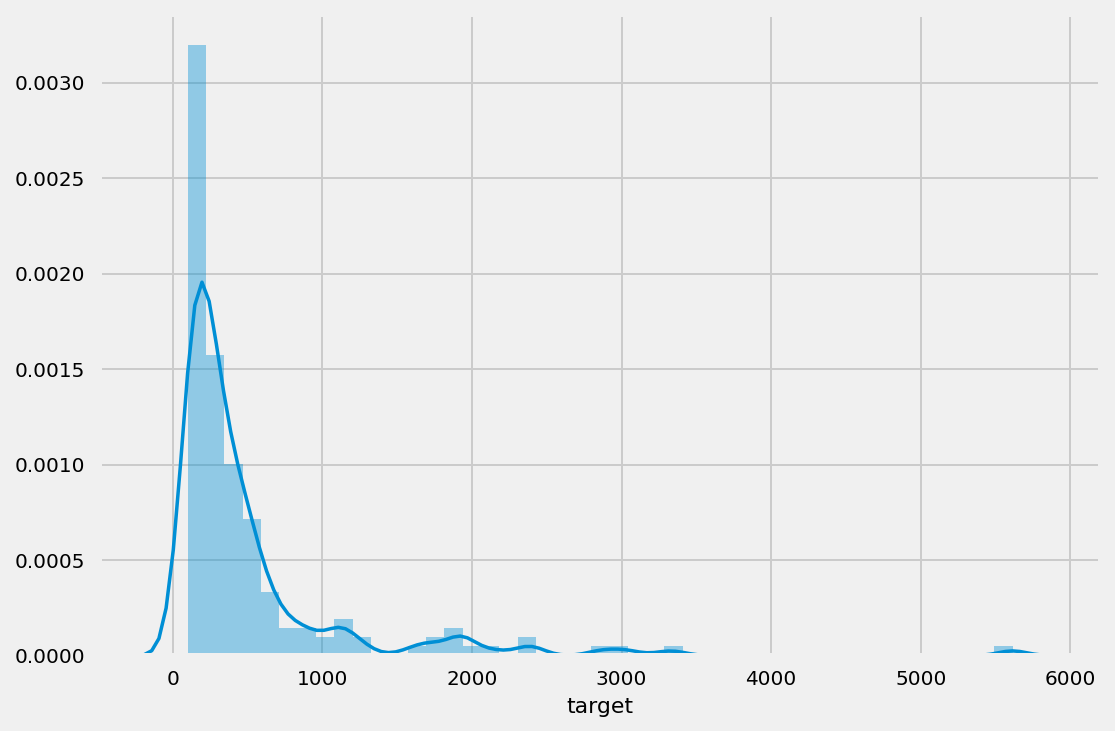

In [ ]:
df = df[df.target!='Other']
sns.distplot(df.target.value_counts());

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df.target)

In [ ]:
df.isna().any()

text      False
target    False
dtype: bool

In [ ]:
df['target'] = ['__label__'+str(s) for s in df['target']]
df = df[['target','text']]

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import csv
train.to_csv('train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test.to_csv('test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [ ]:
# train.sample(5).to_csv('sample.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [ ]:
# import fasttext
# model = fasttext.train_supervised(input='train.txt', epoch=50) --> (17874, 0.5248405505203089, 0.5248405505203089)
# model = fasttext.train_supervised(input='train.txt', epoch=50, lr=0.5, wordNgrams=2, loss='hs') --> (17874, 0.46620789974264293, 0.46620789974264293)
# model = fasttext.train_supervised(input='train.txt', --> (17874, 0.4858453619782925, 0.4858453619782925)
#                                   epoch=25,
#                                   lr=0.2,
#                                   loss='hs',
#                                   autotuneMetric='f1',
#                                   verbose=5,
#                                   minCount=10,
#                                   )
# model = fasttext.train_supervised(input='train.txt', --> (17874, 0.5262392301667226, 0.5262392301667226)
#                                   epoch=50,
#                                   lr=0.1,
#                                   loss='softmax',
#                                   autotuneMetric='f1',
#                                   verbose=5,
#                                   minCount=20,
#                                   )
model = fasttext.train_supervised(input='train.txt', 
                                  epoch=50,
                                  lr=0.1,
                                  loss='softmax',
                                  autotuneMetric='f1',
                                  verbose=5,
                                  minCount=20,
                                  )

In [ ]:
model.test("test.txt", k=1)

(17874, 0.5262392301667226, 0.5262392301667226)

In [ ]:
model.test("test.txt", k=5)

(17874, 0.15201740752253654, 0.6840102942821976)

In [ ]:
xx = df.sample(); xx

,target,text
753556,__label__99,rmes terminal activation . bodytoken


In [ ]:
model.predict(xx.text.tolist()[0], k=5)

(('__label__99', '__label__55', '__label__165', '__label__83', '__label__46'),
 array([1.00007915e+00, 1.08352187e-05, 1.00006037e-05, 1.00005846e-05,
        1.00005755e-05]))

## Pipeline

In [ ]:
!pip install -q fast-bert
!pip install -q fasttext
!pip install -q clean-text[gpl]

In [ ]:
# setup
import os
import pickle
import shutil
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import OrderedDict

warnings.filterwarnings("ignore")
Path(work_path).mkdir(parents=True, exist_ok=True)
os.chdir(work_path)

In [ ]:
shutil.copyfile(os.path.join(save_path,'utils_clean.py'), os.path.join(work_path,'utils_clean.py'))
from utils_clean import clean_l1, clean_l2

shutil.copyfile(os.path.join(save_path,'utils_preprocess.py'), os.path.join(work_path,'utils_preprocess.py'))
from utils_preprocess import *

shutil.copyfile(os.path.join(save_path,'label_encoder.p'), os.path.join(work_path,'label_encoder.p'))
label_encoder = pickle.load(open('label_encoder.p', 'rb'))

shutil.copyfile(os.path.join(save_path,'label_map.p'), os.path.join(work_path,'label_map.p'))
label_map = pickle.load(open('label_map.p', 'rb'))

import fasttext
shutil.copyfile(os.path.join(save_path,'fasttext.bin'), os.path.join(work_path,'fasttext.bin'))
model_fasttext = fasttext.load_model('fasttext.bin')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
vectorizer = CountVectorizer(ngram_range=(1,1))
shutil.copyfile(os.path.join(save_path,'model_countvectorizer_large.p'), os.path.join(work_path,'model_countvectorizer.p'))
model_countvectorizer = pickle.load(open('model_countvectorizer.p', 'rb'))
dtmx = model_countvectorizer['dtm']
vectorizerx = model_countvectorizer['vectorizer']
target_categories = model_countvectorizer['target_categories']
target_labels = model_countvectorizer['target_labels']

shutil.copyfile(os.path.join(save_path,'model_tfidf_large.p'), os.path.join(work_path,'model_tfidf.p'))
model_tfidf = pickle.load(open(os.path.join(work_path,'model_tfidf.p'), 'rb'))

from fast_bert.prediction import BertClassificationPredictor
shutil.unpack_archive(os.path.join(save_path,'fastbert_large_iter2.zip'), work_path, 'zip')
MODEL_PATH = os.path.join(work_path, 'model_out')
model_fastbert = BertClassificationPredictor(
                    model_path=MODEL_PATH,
                    label_path=work_path,
                    multi_label=False,
                    model_type='distilbert',
                    do_lower_case=True)

In [ ]:
X = pd.DataFrame(label_map, index=[0]).T.reset_index()
X.columns = ['Raw_data_labels','processed_labels']
X.to_csv('')

In [ ]:
df_raw = pd.read_pickle(os.path.join('/content/drive/My Drive/','data','raw','data_raw.p'))
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930913 entries, 0 to 930912
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tSubject      930913 non-null  object
 1   mMsgContent   716024 non-null  object
 2   QueryType     930913 non-null  object
 3   SubQueryType  930913 non-null  object
dtypes: object(4)
memory usage: 28.4+ MB


In [ ]:
df_raw['labels_raw'] = df_raw['QueryType'] + ' | ' + df_raw['SubQueryType']
df_raw['labels_raw'].value_counts().to_csv('labels_rawdata.csv')

In [ ]:
# test_set = df_raw.sample(50000, random_state=10)
# def preprocess(X):
#   X = X.drop_duplicates()
#   X = X.dropna(subset=['tSubject', 'mMsgContent'], how='all')
#   X['type'] = X['QueryType'] + ' | ' + X['SubQueryType']
#   X['type'] = X['type'].fillna(' ')
#   X['type_orig'] = X['type']
#   X['type'] = X['type'].apply(clean_l1).str.lower().str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ').apply(clean_l1)
#   X = X[X['type'].isin(list(label_encoder.classes_))]
#   X['subj&msg'] = X['tSubject'] + ' sub_eos_token ' + X['mMsgContent']
#   X = X[['subj&msg','type', 'type_orig']]
#   X.columns = ['text','target', 'type_orig']
#   X = X.dropna()
#   return X
# test_set = preprocess(test_set)
# test_set.describe()

# label_map = test_set[['type_orig','target']].set_index('type_orig').to_dict()['target']
# pickle.dump(label_map, open(os.path.join(#save_path, 'label_map.p'), 'wb'))

In [ ]:
# test_set = df_raw.sample(10000, random_state=10)
# def preprocess(X):
#   X = X.drop_duplicates()
#   X = X.dropna(subset=['tSubject', 'mMsgContent'], how='all')
#   X['type'] = X['QueryType'] + ' | ' + X['SubQueryType']
#   X['type'] = X['type'].fillna(' ')
#   X['type'] = X['type'].apply(clean_l1).str.lower().str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ').apply(clean_l1)
#   X = X[X['type'].isin(list(label_encoder.classes_))]
#   X['subj&msg'] = X['tSubject'] + ' sub_eos_token ' + X['mMsgContent']
#   X = X[['subj&msg','type']]
#   X.columns = ['text','target']
#   X = X.dropna()
#   return X
# test_set = preprocess(test_set)
# test_set.describe()

In [ ]:
  ##### <----- freezed backup -----> #####

# def predict_fasttext(text):
#   text = clean_l1(text)
#   text = preprocess_fasttext(text)
#   preds = model_fasttext.predict(text, k=-1)
#   label_names = label_encoder.inverse_transform([int(x.split('__')[-1]) for x in preds[0]])
#   preds = [(x,y) for x,y in zip(label_names,preds[1])]
#   return preds

# def predict_fastbert(text):
#   text = clean_l1(text)
#   text = preprocess_fastbert(text)
#   preds = model_fastbert.predict(text)
#   preds = [(label_encoder.inverse_transform([int(x[0])])[0],x[1]) for x in preds]
#   return preds

# def predict_countvect(text):
#   text = clean_l1(text)
#   text = clean_l2(text)
#   text = preprocess_countvectorizer(text)
#   cosim = linear_kernel(vectorizerx.transform([text]), dtmx).flatten()
#   preds = [(target_categories[i],cosim[i]) for i in range(len(cosim))]
#   preds = [target_categories[x] for x in np.argsort(-cosim)[:20]]
#   return preds

# def predict_tfidf(text):
#   text = clean_l1(text)
#   text = clean_l2(text)
#   preds = model_tfidf.predict_proba([text])[0]
#   preds = [(label_encoder.inverse_transform([int(x)])[0],y) for x,y in zip(model_tfidf.classes_, preds)]
#   preds.sort(key = lambda x: x[1], reverse=True)  
#   return preds


# query = test_set.sample()
# print('Text: ',query.text.values[0])
# print('Actual Label: ',query.target.values[0])
# print('Predicted Labels: ')
# pred1 = predict_fasttext(query.text.values[0])
# pred2 = predict_fastbert(query.text.values[0])
# pred3 = predict_countvect(query.text.values[0])
# pred4 = predict_tfidf(query.text.values[0])

In [ ]:
# lmr = {label_map[v]:v for v in label_map.keys()}

In [ ]:
def predict_fasttext(text):
  text = clean_l1(text)
  text = preprocess_fasttext(text)
  preds = model_fasttext.predict(text, k=-1)
  preds = [int(x.split('__')[-1]) for x in preds[0]]
  preds = pd.DataFrame([(x,(1/(i+1))) for i,x in enumerate(preds)],
                       columns=['label','rank_fasttext']).set_index('label')
  return preds

def predict_fastbert(text):
  text = clean_l1(text)
  text = preprocess_fastbert(text)
  preds = model_fastbert.predict(text)
  preds = pd.DataFrame([(int(x[0]),(1/(i+1))) for i,x in enumerate(preds)],
                      columns=['label','rank_fastbert']).set_index('label')
  return preds

def predict_tfidf(text):
  text = clean_l1(text)
  text = clean_l2(text)
  preds = model_tfidf.predict_proba([text])[0]
  preds = [(int(x),y) for x,y in zip(model_tfidf.classes_, preds)]
  preds.sort(key = lambda x: x[1], reverse=True)
  preds = pd.DataFrame([(int(x[0]),(1/(i+1))) for i,x in enumerate(preds)],
                    columns=['label','rank_tfidf']).set_index('label')
  return preds

def predict_countvect(text):
  text = clean_l1(text)
  text = clean_l2(text)
  text = preprocess_countvectorizer(text)
  cosim = linear_kernel(vectorizerx.transform([text]), dtmx).flatten()
  preds = [(int(target_categories[i]),cosim[i]) for i in range(len(cosim))]
  preds.sort(key = lambda x: x[1], reverse=True)
  preds = pd.DataFrame([(int(x[0]),(1/(i+1))) for i,x in enumerate(preds)],
                  columns=['label','rank_cvt']).set_index('label')
  return preds

model_weight = {'fasttext':10, 'fastbert':5, 'tfidf':3, 'cvt':2}

def predict(text):
  pred = predict_fasttext(text)
  pred = pred.join(predict_fastbert(text), on='label')
  pred = pred.join(predict_tfidf(text), on='label')
  pred = pred.join(predict_countvect(text), on='label')
  pred['score'] = (pred['rank_fasttext']*model_weight['fasttext']) + \
  (pred['rank_fastbert']*model_weight['fastbert']) + \
  (pred['rank_tfidf']*model_weight['tfidf']) + \
  (pred['rank_cvt']*model_weight['cvt'])
  pred = pred.sort_values(by='score', ascending=False)
  return pred

def predict(text):
  pred = predict_fasttext(text)
  pred = pred.join(predict_tfidf(text), on='label')
  pred = pred.join(predict_countvect(text), on='label')
  pred['score'] = (pred['rank_fasttext']*model_weight['fasttext']) + \
  (pred['rank_tfidf']*model_weight['tfidf']) + \
  (pred['rank_cvt']*model_weight['cvt'])
  pred = pred.sort_values(by='score', ascending=False)
  return pred

In [ ]:
testx = pd.read_excel(os.path.join(save_path,'TSD_v1.xlsx'), sheet_name='Database records')
testx.head()

In [ ]:
print(testx.info())
X = testx[(testx['OriginalQuery']+ ' | '+testx['OriginalSubQuery']).isin(list(set(label_map.keys())))]
print(X.info())
X.head()

In [ ]:
X['text'] = X['tSubject'] + ' sub_eos_token ' + X['mMsgContent']
X['label'] = X['OriginalQuery'] + ' | '+ X['OriginalSubQuery']
X['plabel'] = X['label'].apply(lambda x: label_map[x])
X['clabel'] = label_encoder.transform(X.plabel)
X = X[['text','clabel']]
print(X.info())
X = X.dropna().drop_duplicates()
print(X.info())
X.head()

In [ ]:
from tqdm import tqdm
tqdm.pandas()
top1 = top2 = top3 = 0
for index, row in tqdm(X.iterrows(), total=X.shape[0]):
  text = row.text
  label = row.clabel
  preds = predict(text).index.tolist()[:3]
  if label==preds[0]:
    top1+=1
  elif label==preds[1]:
    top2+=1
  elif label==preds[2]:
    top3+=1
print(top1, top2, top3)

100%|██████████| 1800/1800 [30:07<00:00,  1.00s/it]

1131 258 93


In [ ]:
top1p = top1/X.shape[0]
top2p = top1p + top2/X.shape[0]
top3p = top2p + top3/X.shape[0]

print(top1p, top2p, top3p)

0.6344444444444445 0.7555555555555555 0.8061111111111111


In [ ]:
query = test_set.sample()
# print('Text: ',query.text.values[0])
print('Actual Label: ',query.target.values[0])
print('Actual Label: ',label_encoder.transform([query.target.values[0]]))
predict(query.text.values[0]).head()

Actual Label:  drf requisition status
Actual Label:  [80]


,rank_fasttext,rank_fastbert,rank_tfidf,rank_cvt,score
label,,,,,
80,1.000000,1.000000,0.500000,0.166667,16.833333
81,0.004292,0.500000,1.000000,0.142857,5.828633
100,0.500000,0.027027,0.003922,0.009259,5.165418
6,0.333333,0.003937,0.003802,0.055556,3.475536
154,0.014085,0.014493,0.333333,1.000000,3.213309


In [ ]:
test_set['target_cat'] = label_encoder.transform(test_set.target)
test_set.head()

In [ ]:
from tqdm import tqdm
tqdm.pandas()
top1 = top2 = top3 = 0
for index, row in tqdm(test_set.iterrows(), total=test_set.shape[0]):
  text = row.text
  label = row.target_cat
  preds = predict(text).index.tolist()[:3]
  if label==preds[0]:
    top1+=1
  elif label==preds[1]:
    top2+=1
  elif label==preds[2]:
    top3+=1
print(top1, top2, top3)

100%|██████████| 7183/7183 [2:00:36<00:00,  1.01s/it]

5889 664 151


In [ ]:
top1p = top1/test_set.shape[0]
top2p = top1p + top2/test_set.shape[0]
top3p = top2p + top3/test_set.shape[0]

print(top1p, top2p, top3p)

0.8198524293470695 0.9122929138243074 0.9333147709870528


In [ ]:
def func(subj, msg):
  text = str(subj) + ' sub_eos_token ' + str(msg)
  preds = predict(text).head(3)
  preds.index = label_encoder.inverse_transform(preds.index.tolist())
  preds = preds.rename_axis('label').reset_index()[['label','score']]
  preds.label = preds.label.apply(lambda x: label_map[x])
  preds = preds.T.to_dict()
  preds = str(preds)
  return preds

In [ ]:
x = test_set.sample()
x

In [ ]:
x.text.tolist()[0]

In [ ]:
subj = '<redacted>'
msg = '<redacted>'

In [ ]:
xx = func(subj, msg)
xx

In [ ]:
xx = func(subj, msg)
xx

In [ ]:
pd.Series(test_set['type_orig'].unique()).to_csv('label_list.csv', index=False)

In [ ]:
!pip install -q gradio
import gradio as gr

In [ ]:
gr.Interface(func, 
             [
              gr.inputs.Textbox(lines=2, label='Email Subject'),
              gr.inputs.Textbox(lines=10, label='Email Body'),
             ],
             gr.outputs.Textbox(label='Output Labels')).launch();

In [ ]:
xx = pd.DataFrame(label_map, index=[0]).T.reset_index()
xx.columns = ['plabel', 'olabel']
xx.head()

In [ ]:
xx.olabel.value_counts()